In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Sentiment Analysis**

 * ### Utilizzo del modello "j-hartmann/emotion-english-distilroberta-base"
 * ### Fase di test analizzando il comportamento del modello con delle frasi.

Abbiamo realizzato un file xlsx contente 55 frasi con tipi di emozioni diverse.

Quindi andiamo ad utilizzare tale file per condurre i test.

In [ ]:
base_path = "/content/drive/MyDrive/Workspace_Tesi/Only_Sentiment_Analysis"


Verifichiamo quanti tipi di emozioni sono presenti nel file xlsx che utilizzero per testare il modello

In [ ]:
import pandas as pd

# Carica il file Excel
file_path = base_path + "/frasi_gpt.xlsx"  # Sostituisci con il percorso corretto del file
df = pd.read_excel(file_path)

# Ottieni i tipi unici di emozioni presenti nel file
unique_emotions = df["Emozione"].unique()

# Stampa i tipi di emozioni
print("Tipi di emozioni presenti nel file:")
for emotion in unique_emotions:
    print(emotion)

# Conta i tipi di emozioni
print(f"\nNumero totale di tipi di emozioni: {len(unique_emotions)}")


Tipi di emozioni presenti nel file:
tristezza
paura
gioia
sorpresa
disgusto
neutral
rabbia

Numero totale di tipi di emozioni: 7


In [ ]:
# Conta il numero totale di righe nel file originale
original_count = len(df)

# Identifica le righe duplicate nella colonna 'text'
duplicates = df[df.duplicated(subset="Frase", keep=False)]

# Conta il numero di righe duplicate
duplicate_count = len(duplicates)

# Rimuove le righe duplicate mantenendo solo la prima occorrenza
df_cleaned = df.drop_duplicates(subset="Frase").reset_index(drop=True)

# Conta il numero totale di righe nel file pulito
cleaned_count = len(df_cleaned)

# Stampa i risultati
print(f"Numero totale di righe nel file originale: {original_count}")
print(f"Numero di frasi duplicate trovate: {duplicate_count}")
print(f"Numero totale di righe dopo la rimozione dei duplicati: {cleaned_count}")

Numero totale di righe nel file originale: 55
Numero di frasi duplicate trovate: 0
Numero totale di righe dopo la rimozione dei duplicati: 55


Verifichiamo quanti tipi di emozioni riesce a predirre il modello

In [ ]:
from transformers import pipeline

# Inizializza il modello
emotion_pipeline = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True
)

# Test su una frase di esempio
test_results = emotion_pipeline("This is just a test sentence.")

# Estrai le emozioni rilevabili
detectable_emotions = [emotion["label"] for emotion in test_results[0]]

# Stampa le emozioni rilevabili
print("Emozioni rilevabili dal modello:")
for emotion in detectable_emotions:
    print(emotion)

# Conta le emozioni rilevabili
print(f"\nNumero totale di emozioni rilevabili dal modello: {len(detectable_emotions)}")


Emozioni rilevabili dal modello:
anger
disgust
fear
joy
neutral
sadness
surprise

Numero totale di emozioni rilevabili dal modello: 7


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Analizzando i risultati abbiamo notato che le etichette corrispondo, quindi andiamo a mappare le etichette in modo da assegnare un risultato corretto nel momento in cui verrà effettuata la predizione dell'emozione "ovvero così da confrontare correttamente l'emozione attesa in lingua italiana con l'emozione predetta dal modello in lingua inglese".

In [ ]:
# Installazione delle librerie necessarie
!pip install transformers googletrans==4.0.0-rc1 pandas -q

In [ ]:
# Importa le librerie
from googletrans import Translator
from transformers import pipeline
import pandas as pd

# Inizializza Google Translate
translator = Translator()

# Carica il modello per analisi delle emozioni in inglese
emotion_pipeline = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True
)

# Mappatura delle emozioni (Italiano -> Inglese)
emotion_mapping = {
    "tristezza": "sadness",
    "paura": "fear",
    "gioia": "joy",
    "disgusto": "disgust",
    "sorpresa": "surprise",
    "rabbia": "anger",
    "neutral": "neutral"
}

# Carica il file Excel con le frasi e le emozioni attese
file_path = base_path + "/frasi_gpt.xlsx"  # Percorso del file Excel
df = pd.read_excel(file_path)

# Traduzione delle frasi dall'italiano all'inglese e analisi delle emozioni
results_data = []  # Per salvare i risultati
print("\nAnalizzando le emozioni...")
for i, row in df.iterrows():
    original_text = row["Frase"]
    expected_label_it = row["Emozione"]  # Etichetta attesa in italiano
    expected_label_en = emotion_mapping[expected_label_it]  # Etichetta attesa in inglese

    # Traduzione con Google Translate
    translated_text = translator.translate(original_text, src="it", dest="en").text

    # Predizione delle emozioni
    emotion_results = emotion_pipeline(translated_text)
    sorted_results = sorted(emotion_results[0], key=lambda x: x['score'], reverse=True)
    predicted_label = sorted_results[0]['label']
    confidence = sorted_results[0]['score']

    # Confronto tra predizione ed etichetta attesa
    is_correct = (predicted_label == expected_label_en)
    results_data.append({
        "Frase": original_text,
        "Emozione Attesa (IT)": expected_label_it,
        "Emozione Attesa (EN)": expected_label_en,
        "Traduzione": translated_text,
        "Emozione Predetta": predicted_label,
        "Confidenza Emozione Predetta": confidence,
        "Corretta": is_correct
    })

# Creazione di un DataFrame con i risultati
results_df = pd.DataFrame(results_data)

# Calcolo dell'accuratezza
accuracy = results_df["Corretta"].mean() * 100
print(f"\nAccuratezza del modello: {accuracy:.2f}%")

# Salva i risultati in un file Excel per analisi manuale
results_df.to_excel(base_path + "/result_test.xlsx", index=False)
print("\nRisultati salvati in 'result_test.xlsx'")



Analizzando le emozioni...

Accuratezza del modello: 80.00%

Risultati salvati in 'result_test.xlsx'


Andiamo a visualizzare la percentuale di accuratezza del modello sulle 55 frasi testate.

In [ ]:
accuracy = results_df["Corretta"].mean() * 100
print(f"\nAccuratezza del modello: {accuracy:.2f}%")



Accuratezza del modello: 80.00%


In [ ]:
# Accuratezza per ciascun tipo di emozione
emotion_accuracy = results_df.groupby("Emozione Attesa (EN)")["Corretta"].mean() * 100
print("\nAccuratezza per ciascuna emozione:")
print(emotion_accuracy)


Accuratezza per ciascuna emozione:
Emozione Attesa (EN)
anger        75.000000
disgust      75.000000
fear         75.000000
joy         100.000000
neutral      66.666667
sadness      62.500000
surprise    100.000000
Name: Corretta, dtype: float64


Andiamo a visualizzare la percentuale di accuratezza anche attraverso il grafico a barre

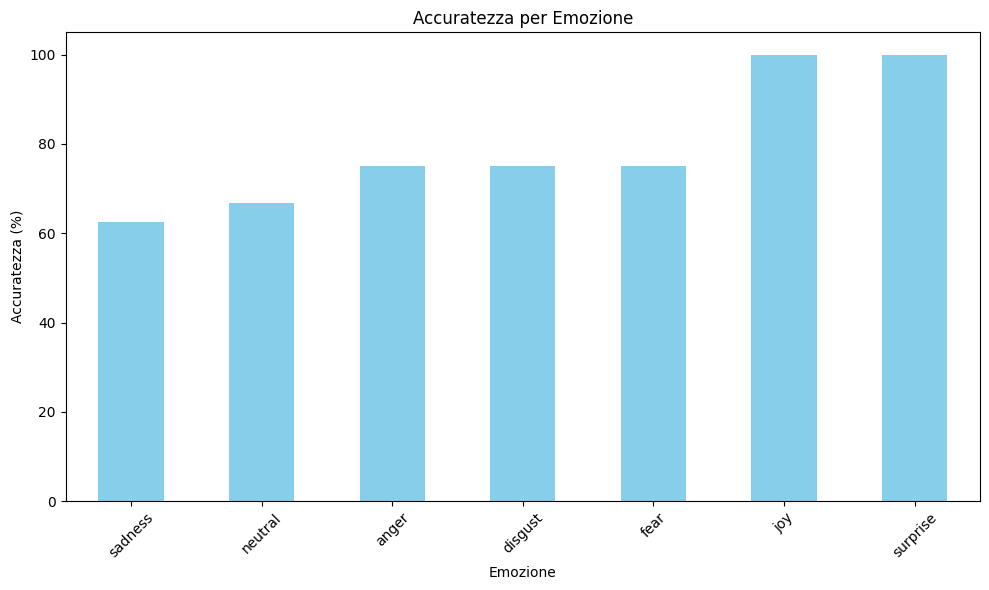

In [ ]:
# Importa le librerie
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Grafico: Accuratezza per ciascun tipo di emozione
plt.figure(figsize=(10, 6))
emotion_accuracy.sort_values().plot(kind="bar", color="skyblue", title="Accuratezza per Emozione")
plt.ylabel("Accuratezza (%)")
plt.xlabel("Emozione")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Grafico per confrontare la distribuzione delle emozioni attese e predette dove:

- Blu: La distribuzione delle emozioni attese (dal dataset).

- Arancione: La distribuzione delle emozioni predette (dal modello).

- Marrone: Quando le emozioni attese e predette si sovrappongono (hanno valori molto simili), i colori blu e arancione si mescolano visivamente, creando un marrone.

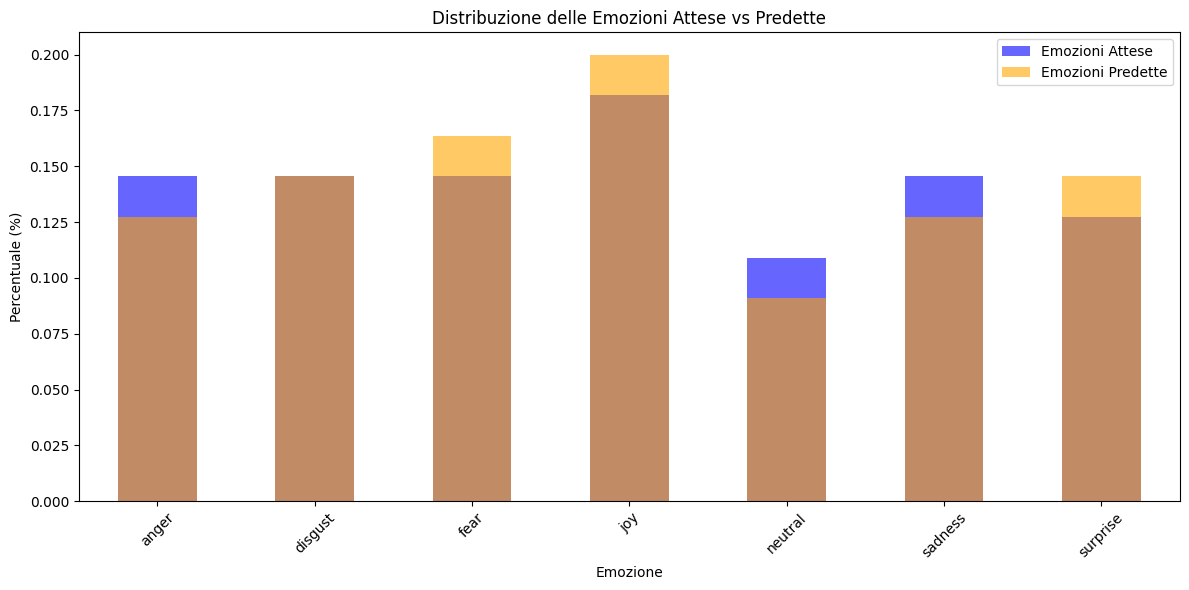

In [ ]:
# Grafico: Distribuzione delle emozioni attese vs predette
plt.figure(figsize=(12, 6))
results_df["Emozione Attesa (EN)"].value_counts(normalize=True).sort_index().plot(kind="bar", alpha=0.6, label="Emozioni Attese", color="blue")
results_df["Emozione Predetta"].value_counts(normalize=True).sort_index().plot(kind="bar", alpha=0.6, label="Emozioni Predette", color="orange")
plt.title("Distribuzione delle Emozioni Attese vs Predette")
plt.ylabel("Percentuale (%)")
plt.xlabel("Emozione")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Andiamo a visualizzare i risultati utilizzando la matrice di confusione

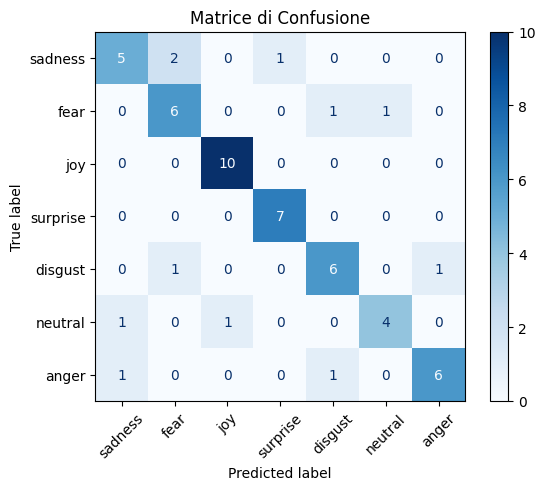

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(results_df["Emozione Attesa (EN)"], results_df["Emozione Predetta"], labels=results_df["Emozione Attesa (EN)"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=results_df["Emozione Attesa (EN)"].unique())
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matrice di Confusione")
plt.show()


Visualizziamo le frasi che non sono state predette correttamente.

In [ ]:
# Predizioni errate
errors_df = results_df[~results_df["Corretta"]]
print("\nPredizioni Errate:")
print(errors_df[["Frase", "Emozione Attesa (IT)", "Emozione Predetta"]].head(10))


Predizioni Errate:
                                                Frase Emozione Attesa (IT)  \
27  Non provo nulla di particolare per questa situ...              neutral   
28              Mi sento sopraffatto dalla tristezza.            tristezza   
33  Il tuo atteggiamento è assolutamente inaccetta...             disgusto   
38  Non riesco a smettere di pensare a quanto tutt...            tristezza   
42  Non so cosa aspettarmi, ma ho un brutto presen...                paura   
43  C'è qualcosa che non mi convince in questa sit...                paura   
45     Mi sento perso e sopraffatto dalla situazione.            tristezza   
48  Non riesco a sopportare come sono stato tratta...               rabbia   
50  È inaccettabile che le cose vadano in questo m...               rabbia   
51  Il sapore di questo piatto mi lascia senza par...             disgusto   

   Emozione Predetta  
27           sadness  
28          surprise  
33             anger  
38              fear  
42    

In [ ]:
# Salva le predizioni errate in un file CSV
errors_df.to_csv("predizioni_errate.csv", index=False)

print("Le predizioni errate sono state salvate nel file 'predizioni_errate.csv'.")


Le predizioni errate sono state salvate nel file 'predizioni_errate.csv'.
